Example 2: Analysis of a resonator from W63
======================

**By: Faustin Carter, 2016**

This notebook imports the data from the Agilent files, creates resonator objects from each datafile, packs those objects into a list, runs a semi-intelligent fitting algorithm predicated on the fact that things don't change too much from one temperature to the next, and then plots the data and fit curves in a nice way.

Once you've understood this example, you should be able to replicate it with your own data simply be writing a custom process_file function and updating the code that finds the datafiles.


Note: Before starting this example, you'll want to read up on list comprehensions and Python's built-in `map` method if you aren't already familiar with them.

In [1]:
#import all the necessary libraries

#For inline notebook figures
%matplotlib inline

#For high-res figures
%config InlineBackend.figure_format = 'retina' 
import glob #For easy file grabbing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs #For plot arrangement
import seaborn as sns #For pretty plots

#Some code to make plots pretty
sns.set_context("poster") #This makes all the text bigger automatically
sns.set_style("ticks",{"xtick.direction" : u"in","ytick.direction" : u"in"})

Load up the `pyRes` modules
----------
You'll need to change the path to reflect wherever you stored the code

In [2]:
#Change directories up one level since for some reason Jupyter can't handle importing submodules
#that are in the current directory. This is really on necessary if you want to run the notebook
#from within the directory.
import os

#Add the current directory you are in to the path since that's where the pyRes module is currently living
import sys
sys.path.append(os.getcwd()+'pyres/')

#Load up the pyres module
import pyres as pr

Make a list of Resonator objects
-----------
Lists are a great way to organize things. `pyRes` includes a tool for easily indexing lists of Resonator objects by temperature and power. Each object has a value called `itemp` that is just the experiment temperature rounded to the nearest 5 mK. This helps a lot with organizing data taken at the 'same' temperature that has fluctuations.

In [3]:
#Path to data (you should look and see what it looks like)
dataPath = './ExampleData/'

#Define a resonator name. The data folder has data for RES-1, RES-2, RES-3, RES-4 so any of those will work.
#Try changing the name to one of the others and rerun the notebook.
resName = 'RES-1'

#We pass the process file and the path to the data, and the built-in routine spits out a list of Resonator objects!
resList = pr.makeResList(pr.process_file, dataPath, resName)

#Create index vectors for all temps and pwrs in the experiment

#itemp = temp rounded to the nearest 5 mK
tempsList = np.unique([res.temp for res in resList])
pwrsList = np.unique([res.pwr for res in resList])

#Let's look at all the temperatures and powers in the experiment
print 'number of resonators in list = ', len(resList)
print 'temps = ', tempsList
print 'powers = ', pwrsList      
print 'temps x powers = ', len(tempsList)*len(pwrsList)

#Can you figure out why the number of resonators in resList is different from temps*powers?
#Hint: look in the data folder at the names of the data files and compare temperatures.

number of resonators in list =  255
temps =  [ 0.089  0.095  0.098  0.1    0.111  0.112  0.113  0.125  0.126  0.127
  0.141  0.142  0.143  0.158  0.159  0.16   0.161  0.175  0.176  0.177
  0.193  0.195  0.196  0.213  0.214  0.215  0.234  0.235  0.25   0.251
  0.271  0.272  0.31   0.341  0.384  0.423  0.463  0.511  0.548  0.587
  0.628  0.629  0.668  0.669  0.707  0.749  0.75   0.787  0.788  0.829
  0.83   0.87   0.871  0.913  0.914  0.955  0.956  0.997  0.998  1.035
  1.036  1.037  1.069  1.071  1.072  1.105  1.107  1.145  1.146  1.147
  1.187  1.189  1.191  1.225  1.226  1.227  1.228  1.229  1.339  1.34
  1.343  1.344  1.415  1.419  1.42   1.421  1.422  1.494  1.495  1.568
  1.569  1.571  1.573  1.643  1.644  1.647  1.649  1.65   1.727  1.73
  1.733  1.809  1.811  1.813  1.814  1.817  1.888  1.889  1.892  1.894
  1.973  1.974  2.037  2.04   2.044  2.045  2.047  2.112  2.115  2.119
  2.121  2.181  2.189  2.19   2.195  2.196  2.263  2.265  2.266  2.268
  2.343  2.347  2.348  2.353  2.35

Fit I and Q data to a model
--------------
This fits I and Q data simultaneously using the built in ``IQcircle`` routine.

In [4]:
for res in resList:
    #Load in the params
    res.load_params(pr.IQcircle_params)
    
    #Do the fit
    res.do_lmfit(pr.IQcircle_fit)

Make a pretty plot
---------
Fits aren't worth anything if you don't plot the results!!

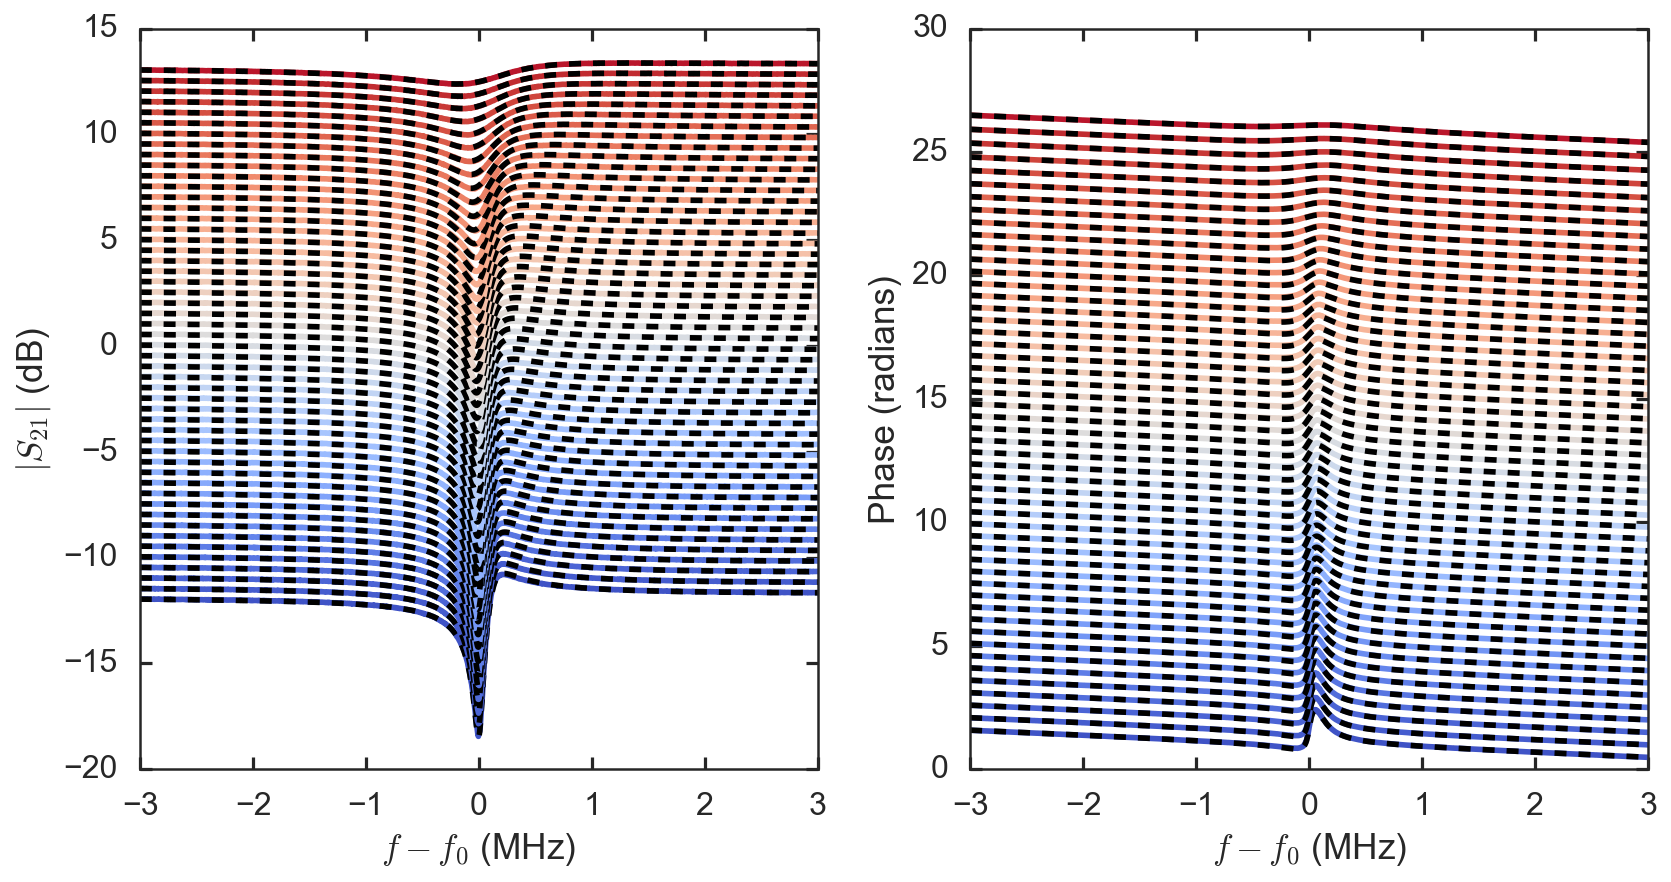

In [10]:
#Lets look at plots from a single power value. Change this to look at other plots
pval = -30

#Make sure the colors look badass
numTraces = int(np.ceil(len(resList)/len(pwrsList))) #Always round up!
sns.set_palette(sns.color_palette("coolwarm", numTraces))

#Set up a figure to overlay the |S21| fits and data
figA = plt.figure()
figA.set_size_inches(12,12)
axMag = figA.add_subplot(221)
axPhase = figA.add_subplot(222)


#Set an index for offsetting the traces in a fancy waterfall way
index2=0

#Loop through 
for index, tval in enumerate(tempsList):

    #grab the right resonator object from the list
    resIndex = pr.indexResList(resList, tval, pval)

    #There are more possible combinations of temp and pwr than there are resonators.
    #indexResList returns None if a combination is invalid.
    if resIndex is not None:
        res = resList[resIndex]
        resf0 = res.lmfit_result.params['f0'].value
        axMag.plot((res.freq-resf0)*1e-6,10*np.log10(res.mag)+index2/2.0)
        axMag.plot((res.freq-resf0)*1e-6,10*np.log10(res.resultMag)+index2/2.0, 'k--')
        
        axPhase.plot((res.freq-resf0)*1e-6,res.phase+index2/2.0)
        axPhase.plot((res.freq-resf0)*1e-6,res.resultPhase+index2/2.0, 'k--')
        
        #Stack the next one up just a little bit more
        index2+=1
        
axMag.set_xlabel('$f-f_0$ (MHz)')
axMag.set_ylabel('$|S_{21}|$ (dB)')

#Comment this out if you want to see the full curves
axMag.set_xlim(-3,3)

axPhase.set_xlabel('$f-f_0$ (MHz)')
axPhase.set_ylabel('Phase (radians)')

#Comment this out if you want to see the full curves
axPhase.set_xlim(-3,3)

figA.tight_layout()

In [6]:
#Save that figure in the local directory. You worked hard for it!
figA.savefig('Mag-and-Phase-E2.png')

Use the ``ResonatorSweep`` object to look at fit parameters
---
Usually what we are really interested in is the fit parameters as functions of temperature at different powers. There is a nice object we can use to look at this easily.

In [7]:
#Pack all of the fit data into resSweep, and use the 'block' index method
#to figure out which temperatures are nominally the same
resSweep = pr.ResonatorSweep(resList, index='block')

#Look at the first few frequencies:
print '\nf0\n',resSweep['f0'].head()

#and the first few reduced-chi-squared values
print '\nredchi\n',resSweep['redchi'].head()


f0
              -50.0         -40.0         -30.0         -20.0         -10.0
96.0   8.174976e+09  8.174915e+09  8.174903e+09  8.174897e+09  8.174890e+09
112.0  8.174941e+09  8.174883e+09  8.174875e+09  8.174871e+09  8.174866e+09
126.0  8.174914e+09  8.174855e+09  8.174842e+09  8.174838e+09  8.174835e+09
142.0  8.174883e+09  8.174821e+09  8.174808e+09  8.174806e+09  8.174806e+09
160.0  8.174860e+09  8.174802e+09  8.174785e+09  8.174787e+09  8.174789e+09

redchi
          -50.0     -40.0     -30.0     -20.0     -10.0
96.0   0.434204  0.212281  0.021694  0.002706  0.005322
112.0  0.408250  0.249672  0.023791  0.002695  0.003688
126.0  0.385771  0.295370  0.027315  0.003138  0.001645
142.0  0.360949  0.336420  0.030906  0.003150  0.000586
160.0  0.352943  0.428929  0.036915  0.003826  0.000552


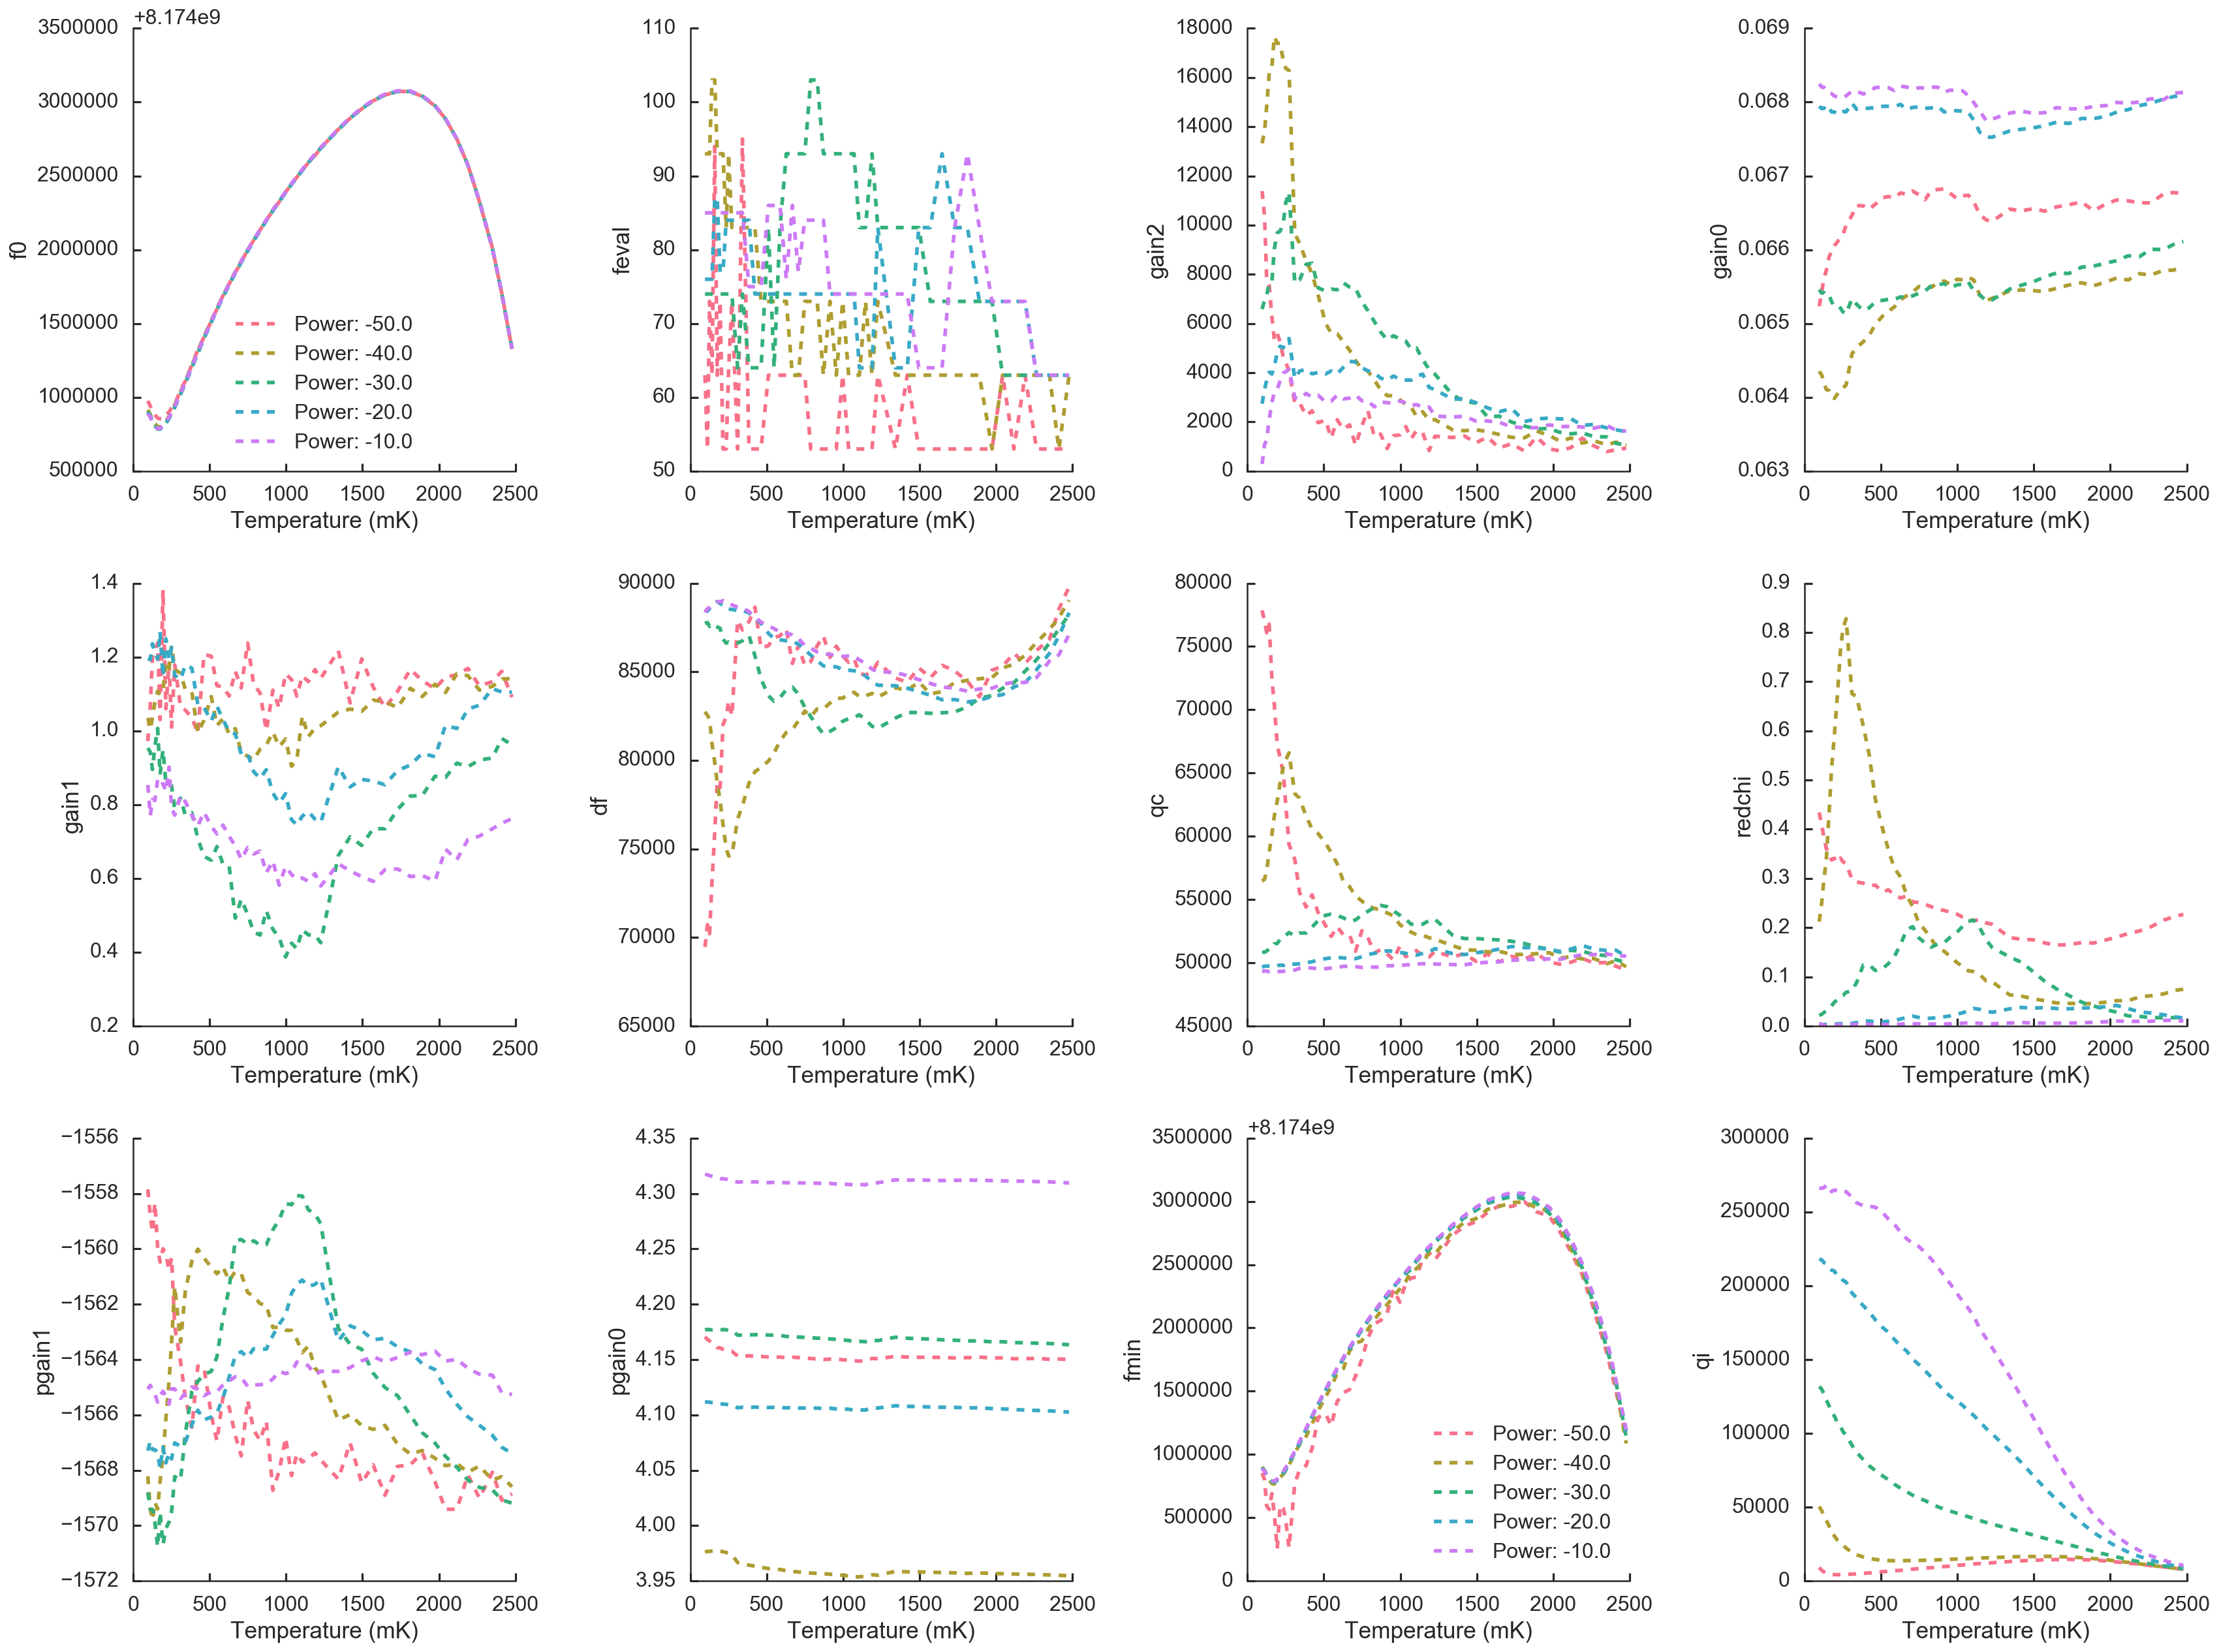

In [15]:
#Now let's make a plot of all the parameters!

#Colors again!
sns.set_palette(sns.color_palette("husl", len(resSweep.pvec)))

#Plot everything except for a couple keys
figS = resSweep.plotParamsVsTemp(keysToIgnore=['Ioffset', 'Qoffset', 'chisq'])

sns.despine()
figS.tight_layout()

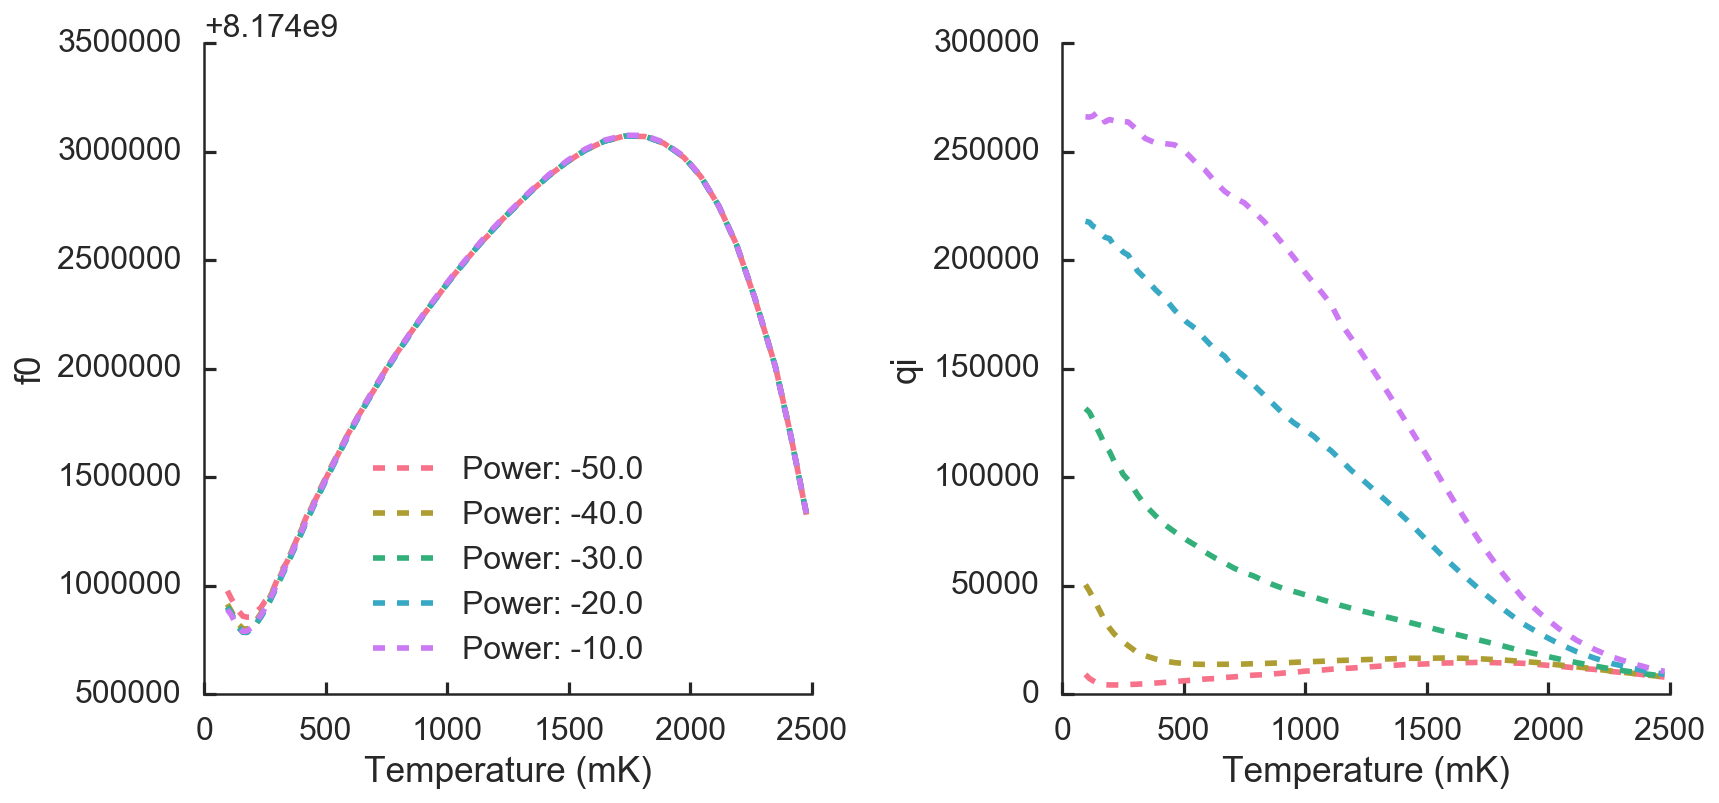

In [18]:
#Or maybe you just want to look at a couple of keys:
figS2 = resSweep.plotParamsVsTemp(keysToPlot=['f0', 'qi'])
sns.despine()
figS2.tight_layout()